In [42]:
#!pip install tensorflow~=2.6.0
#!pip install keras~=2.6.0
import PIL
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.python.keras import layers
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
import time
from IPython import display
%matplotlib inline

In [51]:
def normalize(layer):
    return tf.divide(tf.subtract(layer,tf.reduce_min(layer) ), tf.subtract(tf.reduce_max(layer),tf.reduce_min(layer)))
#take random noise as input and a starting shape that has dimensions ((7,14,28), (7,14,28), (128, 256, 512)
print(tf.__version__)
def make_generator_model(): 
    model = tf.keras.Sequential() 
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) 
    model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU()) 
    model.add(layers.Reshape((7, 7, 256))) 
    #assert model.output_shape == (None, 7, 7, 256) 
    # Note: None is the batch size 
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)) 
    #assert model.output_shape == (None, 14, 14, 128)
    model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(4, 4), padding='same', use_bias=False))
    #assert model.output_shape == (None, 28, 28, 64) 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) 

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(4, 4), padding='same', use_bias=False))
    #assert model.output_shape == (None, 224, 224, 32) 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) 

    model.add(layers.Conv2D(3, (5, 5), padding='same', use_bias=False, activation='tanh')) 
    #assert model.output_shape == (None, 224, 224, 3)
    model.add(layers.BatchNormalization(center=True,scale=True, gamma_initializer=tf.constant_initializer(0.5), beta_initializer=tf.constant_initializer(0.5)))
    #normalizes values between 0 and 1

    return model


2.6.5


In [52]:
generator = make_generator_model()
noise = tf.random.normal([1, 100]) #replace 1 with batch size
generated_image = generator(noise, training=False)

(224, 224, 3)


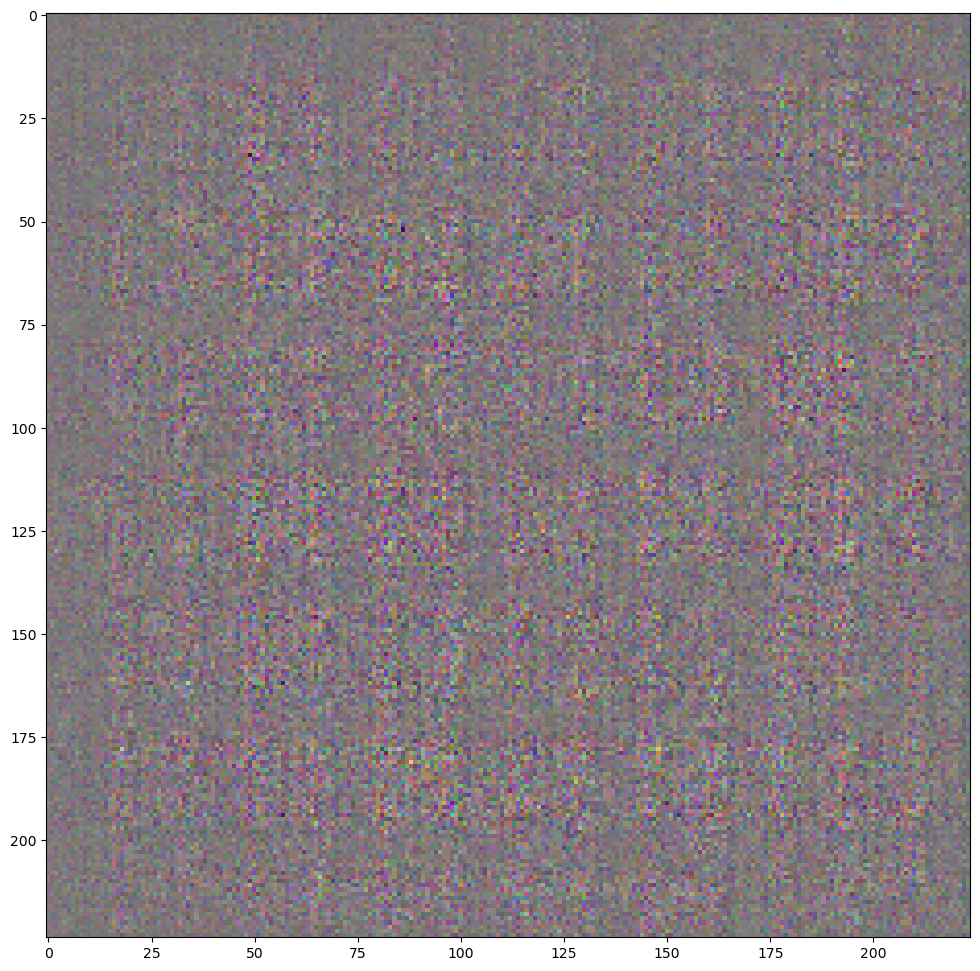

In [54]:
plt.figure(figsize=(12,12))
print(generated_image[0, :, :, :].shape) #check that image has scaled to correct size
plt.imshow(generated_image[0, :, :, :])#for an RGB image values must be scaled from 0 to 1
plt.show()                             #while greyscale will automatically shift values to be between 0 and 1

In [30]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(4, 4), padding='same', input_shape=[224, 224, 3]))
    model.add(layers.LeakyReLU())  #shape(56, 56, 32)
    model.add(layers.Dropout(0.3)) #dropout is used to prevent overfitting by setting inputs to 0 at a rate determined by paremeter 
                                   #while training. While have to test how this function affects performance

    model.add(layers.Conv2D(64, (5, 5), strides=(4, 4), padding='same'))
    model.add(layers.LeakyReLU())   #shape(14, 14, 64)
    model.add(layers.Dropout(0.3)) 

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())  #shape(7, 7, 128)
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())  #shape(7, 7, 256)
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten()) #fits all elements into 1 dimension
    model.add(layers.Dense(1))  #Creates a densely-connected layer of size 1

    return model

In [37]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00766756]], shape=(1, 1), dtype=float32)


In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model